# DORIS Range-Rate Observation Equation (Simplistic Approach)

We can formulate range-rate observation equations using the Doppler count data extracted from the DORIS RINEX files. A simplistic approach (disregarding all errors) would be to use the simple equation:

$$ \frac{\phi (t_2) - \phi (t_1)}{\Delta t} \cdot \frac{c}{f} = \frac{\rho (t_2) - \rho (t_1)}{\Delta t} $$ in [m/sec], where $\rho (t)$ is the beacon-to-satellite distance.

In [1]:
# import dsoclasses
import datetime
import attotime
import numpy as np
from dsoclasses.rinex.doris.rinex import DorisRinex
from dsoclasses.time.pyattotime import at2pt, fsec2asec
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations
from dsoclasses.gnss import systems as gs
from dsoclasses.gnss import algorithms as alg
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

We will need onr DORIS RINEX file and a corresponding sp3.

In [2]:
drinex = "../../data/s6arx24001.001"
dsp3 = "../../data/ssas6a20.b23357.e24001.DG_.sp3.001"

We will also need an interpolator to compute satellite state at any observation epoch.

In [3]:
sp3 = sp3c.Sp3(dsp3)
satid = sp3.sat_ids[0]
sp3_data = sp3.get_satellite(satid, True)
intrp = interpolator.OrbitInterpolator(satid, sp3_data, 1800, 12, 'CubicSpline')

Intitialize the `DorisRinex` instance and select a beacon (Dionysos/DIOB).

In [4]:
rnx = DorisRinex(drinex)

# DIOB DORIS beacon
diob = 'D31'

# approx. DIOB coordinats, see https://ids-doris.org/network/sitelogs/station.html?code=DIONYSOS
diob_xyz=np.array([4595212.468, 2039473.691, 3912617.891])

In [16]:
# initially, no previous phase observation ...
t1=None

# store results here 
t = []; res=[];

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == diob:
            # use the block, RINEX provided clock correction to get to (approximate) TAI
            # date TAI = epoch + receiver clock offset
            t2 = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset()*1e9)
            # satellite position at the current epoch (taking into account signal travel time)
            satx, saty, satz, _ = alg.sat_at_emission_time(diob_xyz, t2, intrp)
            # L1 measurement
            L2 = data['L1']['value']
            # beacon-to-satellite distance
            r2 = np.linalg.norm(np.array([satx, saty, satz])-np.array(diob_xyz))
            # if we have a previous measurement, within 10 sec ...
            if t1 is not None and (t2 - t1).total_seconds() <= 10.:
                # computed range-rate
                crr = (r2 - r1) / (float((t2-t1).total_nanoseconds()) * 1e-9)
                # observed range-rate
                orr = ((L2-L1) / (float((t2-t1).total_nanoseconds()) * 1e-9)) * (299792458./2036.25e6)
                # very loose outlier detection
                if abs(orr - crr) > 100.:
                    pass
                else:
                    t.append(at2pt(t2))
                    res.append(orr - crr)
            # prepare for next measurement
            r1 = r2
            t1 = t2
            L1 = L2

Plot residuals

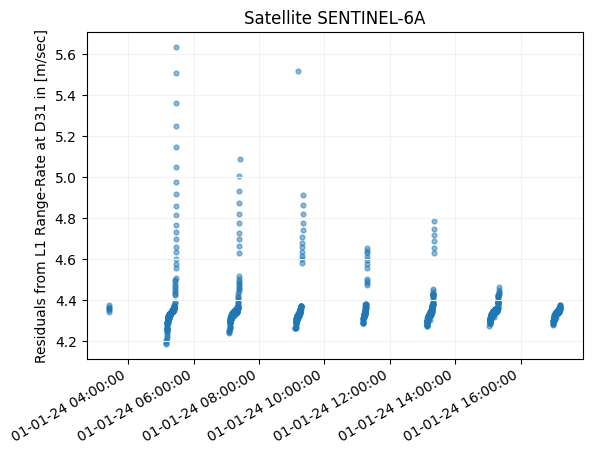

In [17]:
plt.scatter([at2pt(ti) for ti in t], res, alpha=0.5, s=12)
# plt.plot([at2pt(ti) for ti in t], res, alpha=0.3, linewidth=1)

plt.grid(color='0.95')
plt.ylabel(f"Residuals from L1 Range-Rate at {diob} in [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")

# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
# auto-rotate date labels for readability
plt.gcf().autofmt_xdate()

plt.show()

## Correlation with Elevation

In [13]:
lat, lon, hgt = transformations.car2ell(*diob_xyz)
Rt = transformations.geodetic2lvlh(lat, lon)
R = Rt.transpose()

def azele(rsat, rsta):
    enu = R @ (rsat - rsta)
    r  = np.linalg.norm(enu)
    az = np.arctan2(enu[0], enu[1])
    el = np.arcsin(enu[2] / r)
    return r, az, el

t1=None
els = []; res=[];
for block in rnx:
    for beacon, data in block:
        if beacon == diob:
            t2 = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset()*1e9)
            satx, saty, satz, _ = alg.sat_at_emission_time(diob_xyz, t2, intrp)
            L2 = data['L1']['value']
            r2 = np.linalg.norm(np.array([satx, saty, satz])-np.array(diob_xyz))
            _, _, el = azele(np.array((satx, saty, satz)), np.array(diob_xyz))
            if t1 is not None and (t2 - t1).total_seconds() <= 10.:
                crr = (r2 - r1) / (float((t2-t1).total_nanoseconds()) * 1e-9)
                orr = ((L2-L1) / (float((t2-t1).total_nanoseconds()) * 1e-9)) * (299792458./2036.25e6)
                if abs(orr - crr) > 100.:
                    pass
                else:
                    res.append(orr - crr)
                    els.append(np.degrees(el))
            r1 = r2
            t1 = t2
            L1 = L2

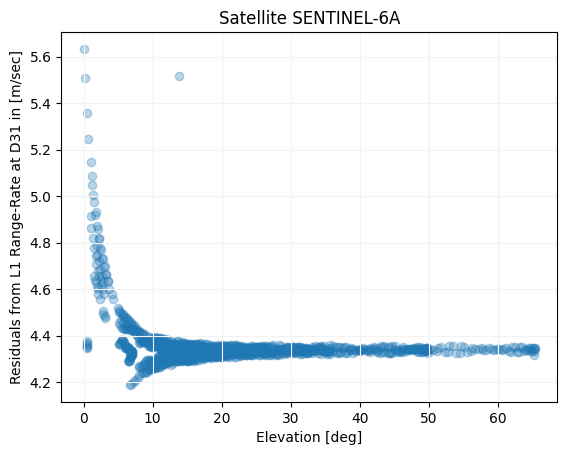

In [15]:
plt.scatter(els, res, alpha=0.3, marker='o')
plt.grid(color='0.95')
plt.ylabel(f"Residuals from L1 Range-Rate at {diob} in [m/sec]")
plt.xlabel("Elevation [deg]")
plt.title(f"Satellite {rnx.sat_name}")
plt.show()